# Energy and error over time

This notebook visualizes:
- **Error vs time** from `error.csv`
- **Energy vs time** from `energy.csv`

Data sources (Newmark run):
- `/home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/results/newmark-standing-mode-wsol/run-R1-N160x160-dt0_005-T10-gamma0_5-beta0_25/error.csv`
- `/home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/results/newmark-standing-mode-wsol/run-R1-N160x160-dt0_005-T10-gamma0_5-beta0_25/energy.csv`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [3]:
error_path = Path('/home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/results/newmark-standing-mode-wsol/run-R1-N160x160-dt0_005-T10-gamma0_5-beta0_25/error.csv')
energy_path = Path('/home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/results/newmark-standing-mode-wsol/run-R1-N160x160-dt0_005-T10-gamma0_5-beta0_25/energy.csv')

df_err_raw = pd.read_csv(error_path)
df_eng_raw = pd.read_csv(energy_path)

def _pick_time_col(df: pd.DataFrame) -> str:
    cand = [c for c in df.columns if str(c).strip().lower() in ('t', 'time', 'times', 'timestamp')]
    if cand:
        return cand[0]
    # fallback: first numeric column
    num = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    return num[0] if num else df.columns[0]

def _pick_value_col(df: pd.DataFrame, kind: str, time_col: str) -> str:
    low = {c: str(c).strip().lower() for c in df.columns}
    if kind == 'error':
        pref = ['error', 'err', 'l2', 'h1', 'linf', 'infty']
    else:
        pref = ['energy', 'e', 'hamiltonian']
    scored = []
    for c in df.columns:
        if c == time_col:
            continue
        name = low[c]
        score = sum(p in name for p in pref)
        scored.append((score, c))
    scored.sort(reverse=True, key=lambda x: x[0])
    if scored and scored[0][0] > 0:
        return scored[0][1]
    # fallback: first numeric column different from time
    num = [c for c in df.columns if c != time_col and pd.api.types.is_numeric_dtype(df[c])]
    if num:
        return num[0]
    # last resort: second column if exists
    return df.columns[1] if len(df.columns) > 1 else df.columns[0]

def _clean_xy(df: pd.DataFrame, kind: str) -> pd.DataFrame:
    df = df.copy()
    tcol = _pick_time_col(df)
    ycol = _pick_value_col(df, kind=kind, time_col=tcol)
    df[tcol] = pd.to_numeric(df[tcol], errors='coerce')
    df[ycol] = pd.to_numeric(df[ycol], errors='coerce')
    out = df[[tcol, ycol]].rename(columns={tcol: 't', ycol: kind}).dropna()
    out = out.sort_values('t').reset_index(drop=True)
    return out

df_err = _clean_xy(df_err_raw, kind='error')
df_eng = _clean_xy(df_eng_raw, kind='energy')

df_err.head(), df_eng.head()

(      t     error
 0  0.05  0.001935
 1  0.10  0.003510
 2  0.15  0.004938
 3  0.20  0.006240
 4  0.25  0.007358,
       t   energy
 0  0.05  2.47551
 1  0.10  2.47235
 2  0.15  2.46755
 3  0.20  2.46203
 4  0.25  2.45685)

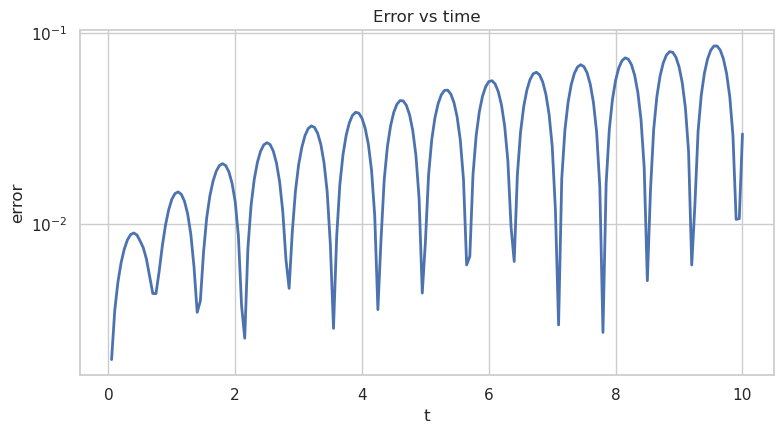

In [4]:
plt.figure(figsize=(8, 4.5))
ax = sns.lineplot(data=df_err, x='t', y='error', linewidth=2)
ax.set_title('Error vs time')
ax.set_xlabel('t')
ax.set_ylabel('error')
if (df_err['error'] > 0).all():
    ax.set_yscale('log')
plt.tight_layout()

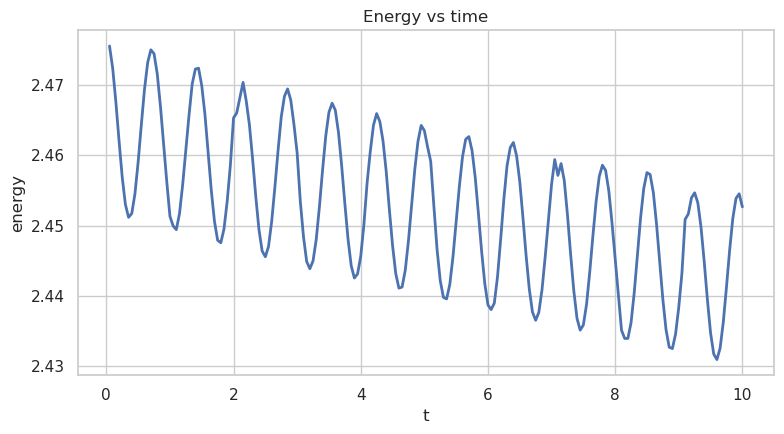

In [5]:
plt.figure(figsize=(8, 4.5))
ax = sns.lineplot(data=df_eng, x='t', y='energy', linewidth=2)
ax.set_title('Energy vs time')
ax.set_xlabel('t')
ax.set_ylabel('energy')
plt.tight_layout()

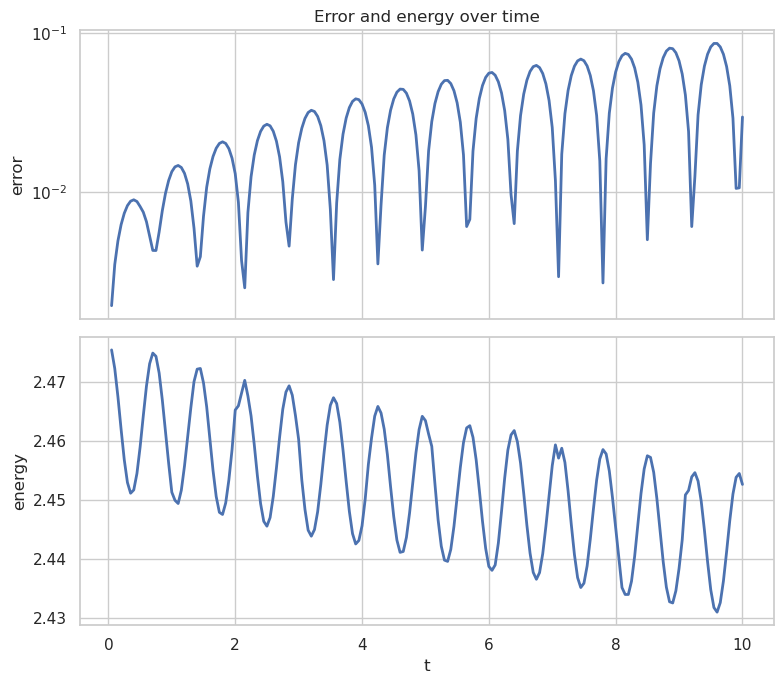

In [6]:
# Optional: combined view (shared x)
fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

sns.lineplot(data=df_err, x='t', y='error', linewidth=2, ax=axes[0])
axes[0].set_title('Error and energy over time')
axes[0].set_ylabel('error')
if (df_err['error'] > 0).all():
    axes[0].set_yscale('log')

sns.lineplot(data=df_eng, x='t', y='energy', linewidth=2, ax=axes[1])
axes[1].set_xlabel('t')
axes[1].set_ylabel('energy')

plt.tight_layout()